In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Model and Dataset
We load a pretrained VGG16 model and a test dataset.

In [2]:
from datasets import get_dataset 
from torchvision.models import vgg16

model = vgg16(weights="IMAGENET1K_V1")
model.eval()
model = model.cuda()

dataset_fn = get_dataset("imagenet_pexels")
dataset = dataset_fn(data_path="datasets/pexels", preprocessing=True, split="train")
dataset_fv = dataset_fn(data_path="datasets/pexels", preprocessing=False, split="train")

Loading imagenet_pexels


## Concept Attributions
We set up the computation of concept attributions. Here, the first composite is for LRP with EpsilonPlusFlat rule for localizing concepts in the input. 
The second composite is for the LRP-epsilon rule that is used to attribute concepts. The canonizer is specific to the VGG model.

In [3]:
from zennit.torchvision import VGGCanonizer
from utils.lrp_composites import EpsilonPlusFlat, EpsilonComposite
from crp.attribution import CondAttribution

attribution = CondAttribution(model)
composite = EpsilonPlusFlat(canonizers=[VGGCanonizer()])
composite_eps = EpsilonComposite(canonizers=[VGGCanonizer()])

## Feature Visualization
We initialize the feature visualization class that will be used to visualize the concepts.

In [4]:
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from utils.crp import FeatVis

layer_names = get_layer_names(model, [torch.nn.Conv2d])
layer_map = {layer: ChannelConcept() for layer in layer_names}

fv = FeatVis(attribution, dataset_fv, layer_map, preprocess_fn=dataset.preprocessing, path=f"crp_files/vgg16_imagenet_pexels")
fv.run(composite, 0, len(dataset) // 1, batch_size=32) # needs to be performed once
print("CRP preprocessing done.")

Running Analysis...


100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


100%|██████████| 26/26 [00:00<00:00, 926.97it/s]


CRP preprocessing done.


## PCX Preprocessing
Compute concept attributions and activations over the dataset.

In [7]:
from tqdm import tqdm
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8)
cc = ChannelConcept()

activations = []
attributions = []
outputs = []

for i, (x, y) in enumerate(tqdm(dataloader)):
    x = x.to("cuda").requires_grad_()
    condition = [{"y": id_} for id_ in y]
    attr = attribution(x, condition, composite_eps, record_layer=layer_names)
    
    attributions.append(cc.attribute(attr.relevances["features.28"], abs_norm=True))
    activations.append(attr.activations["features.28"].amax((-2, -1)))
    outputs.extend([attr.prediction.detach().cpu()])
    
activations = torch.cat(activations)
attributions = torch.cat(attributions)
outputs = torch.cat(outputs)
indices = np.arange(len(dataset))
attr = attributions[outputs.argmax(1) == 130]
act = activations[outputs.argmax(1) == 130]
indices = indices[outputs.argmax(1) == 130]

100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


## StrategyMap Visualization with UMAP
Let's visualize the attributions and activations using UMAP.
Here, each points corresponds to one sample and the respective concept attributions or activations.

In [8]:
from umap import UMAP

embedding_attr = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
X_attr = embedding_attr.fit_transform(attr.detach().cpu().numpy())
x_attr, y_attr = X_attr[:, 0], X_attr[:, 1]

embedding_act = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
X_act = embedding_act.fit_transform(act.detach().cpu().numpy())
x_act, y_act = X_act[:, 0], X_act[:, 1]


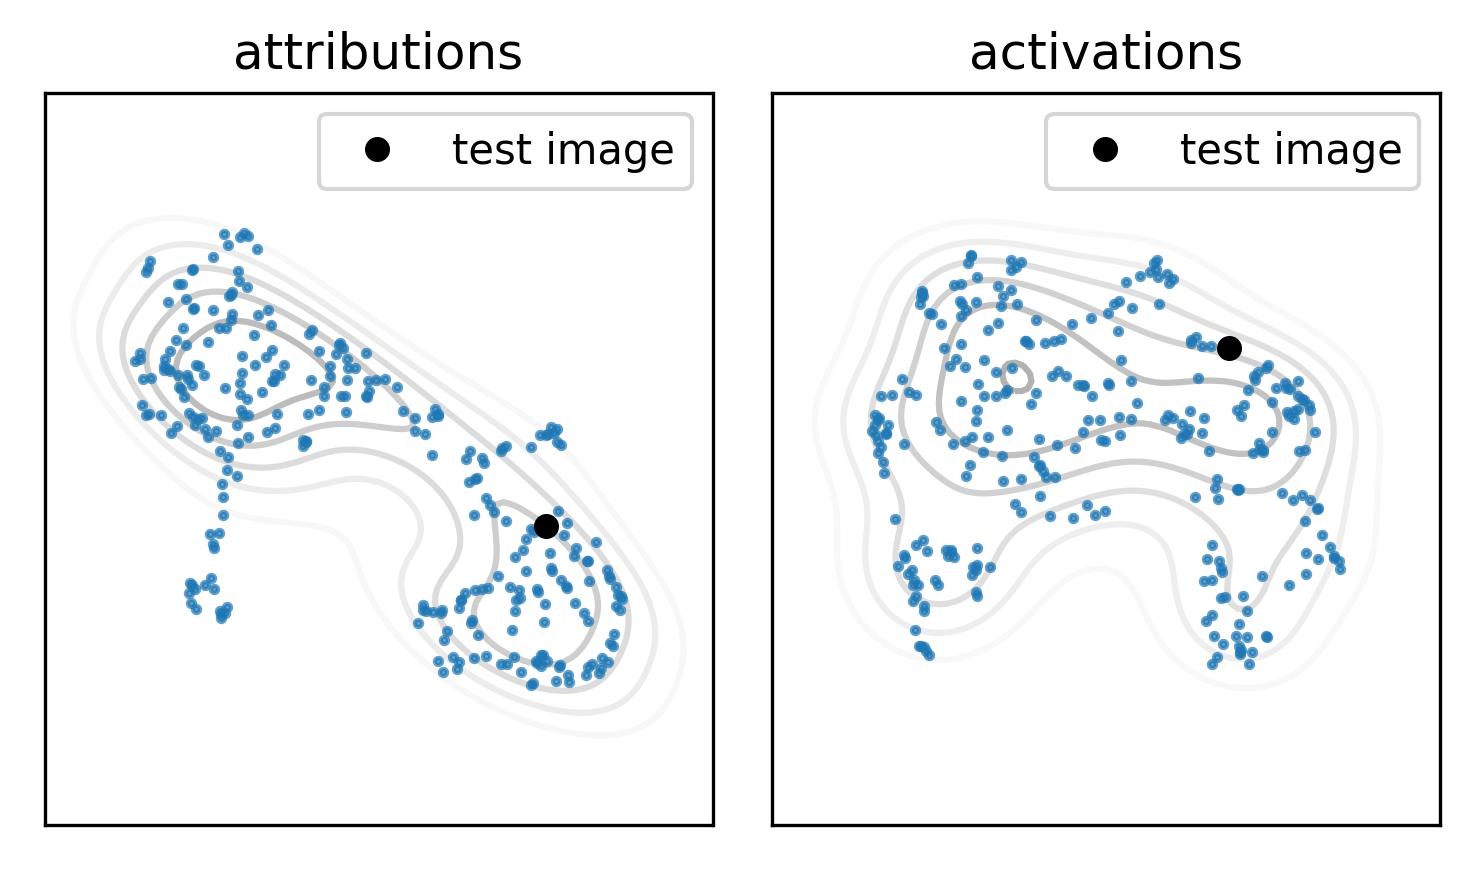

In [9]:
from scipy import stats
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(5, 3), facecolor='white')
for i, X in enumerate([X_attr, X_act]):
    x, y = X[:, 0], X[:, 1]
    xmin = x.min() - 2
    xmax = x.max() + 2
    ymin = y.min() - 2
    ymax = y.max() + 2
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values, 0.5)
    Z = np.reshape(kernel(positions).T, X.shape).T
    axes[i].contour(Z, extent=[xmin, xmax, ymin, ymax], cmap="Greys", alpha=0.3, extend='min', vmax=Z.max() * 1, zorder=0)
    axes[i].scatter(x, y, s=3, alpha=0.7, zorder=1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(["attributions", "activations"][i])
    axes[i].plot(x[0], y[0], 'ko', markersize=5, label="test image")
    axes[i].legend()
plt.tight_layout()
fig.show()


## Compute Prototypes
Let's compute the prototypes for the attributions and activations and also add them to the embedding plot.

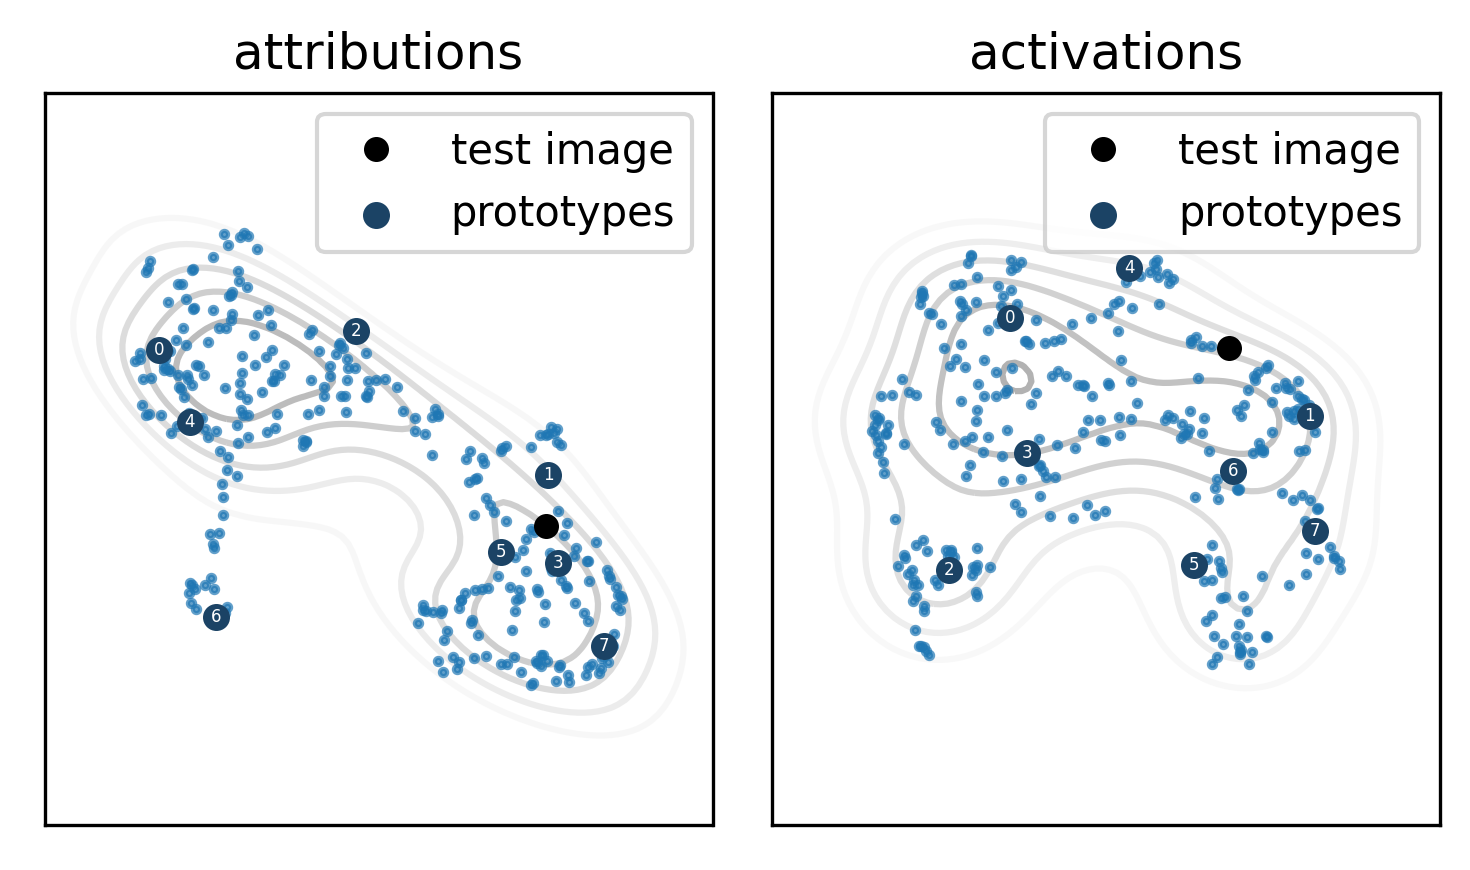

In [10]:
from sklearn.mixture import GaussianMixture

prototypes = []
for i, (X, emb) in enumerate([(attr, embedding_attr), (act, embedding_act)]):
    gmm = GaussianMixture(n_components=8, random_state=0).fit(X.detach().cpu().numpy())
    prototypes.append(gmm.means_)
    mean = emb.transform(gmm.means_)
    axes[i].scatter(mean[:, 0], mean[:, 1], s=30, c="#1B4365", zorder=2, label="prototypes")
    for k, prot in enumerate(mean):
        axes[i].text(prot[0], prot[1], k, fontsize=4, color="white", ha="center", va="center")
    axes[i].legend()

display(fig)


## Prototype Visualization
Let's retrieve the samples that are closest to the prototypes to better understand what they represent. 

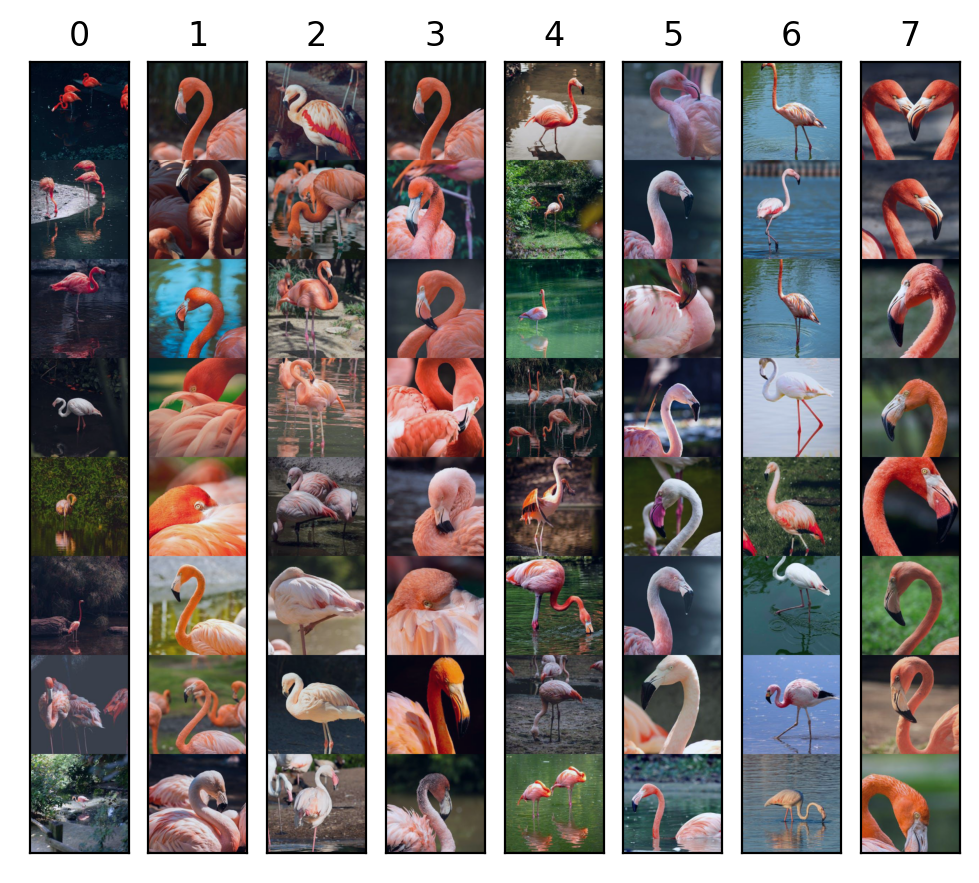

In [11]:
from torchvision.utils import make_grid
import zennit.image as zimage
from crp.image import imgify

proto_attr = prototypes[0]

distances = np.linalg.norm(attr[:, None, :].detach().cpu() - proto_attr, axis=2)
prototype_samples = np.argsort(distances, axis=0)[:8]
prototype_samples = indices[prototype_samples]

fig, axs = plt.subplots(1, 8, figsize=(6, 8), dpi=200, facecolor='white')


N_PROTOTYPES = 8
for i in range(N_PROTOTYPES):
    grid = make_grid(
        [dataset[prototype_samples[j][i]][0] for j in range(8)],
        nrow=1,
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()))
    img = imgify(grid)
    axs[i].imshow(img)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f"{i}")

## Concept Visualization with RelMax
We can see flamingos in different poses and orientations in the prototypes. Let's understand the concepts that are most relevant to these prototypes.

<ipython-input-12-19854ab7be5a>:47: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  [resize(torch.from_numpy(np.asarray(i)).permute((2, 0, 1))) for i in ref_imgs[top_concepts[i]]],


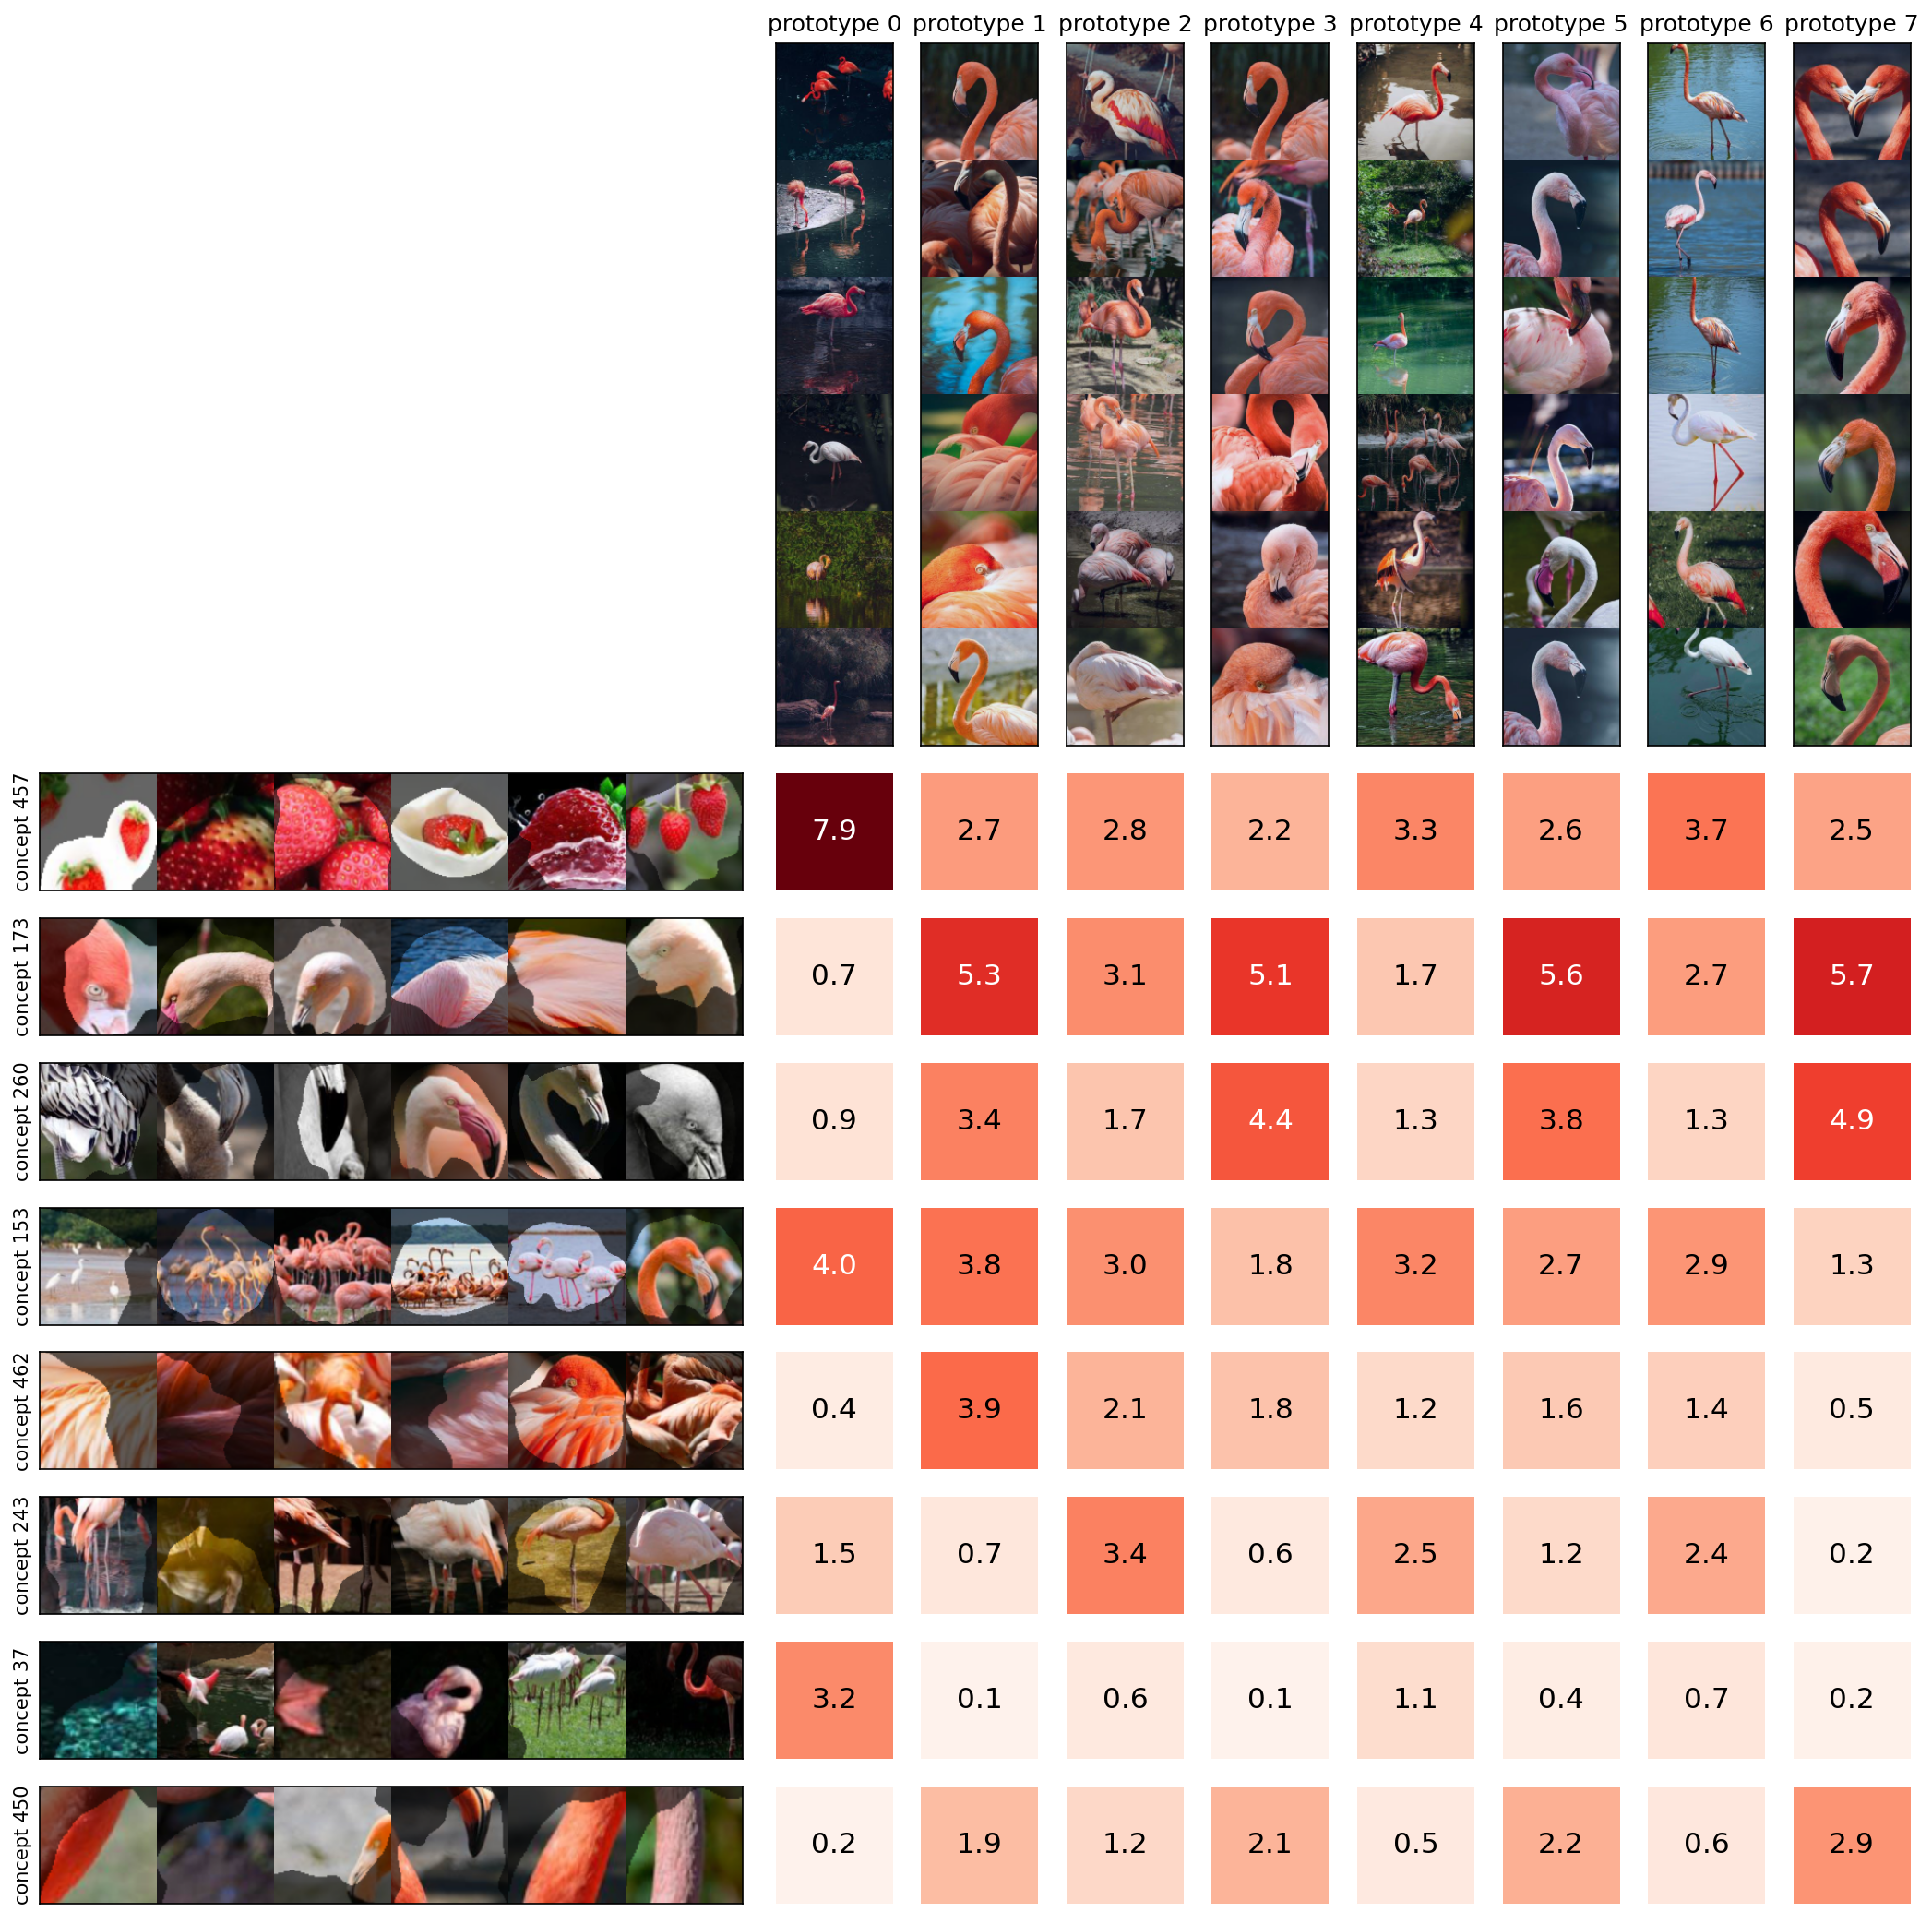

In [12]:
from utils.render import vis_opaque_img_border
import torchvision

proto = torch.from_numpy(proto_attr)
top_concepts = torch.topk(proto, 3).indices.flatten().unique()
top_concepts = top_concepts[proto[:, top_concepts].amax(0).argsort(descending=True)].tolist()
concept_matrix = proto[:, top_concepts].T
N_CONCEPTS = len(top_concepts)

n_refimgs = 12
ref_imgs = fv.get_max_reference(top_concepts, "features.28", "relevance", (0, 6), composite=composite, rf=True,
                                    plot_fn=vis_opaque_img_border, batch_size=6)

fig, axs = plt.subplots(nrows=N_CONCEPTS + 1, ncols=N_PROTOTYPES + 1, figsize=(N_PROTOTYPES + 6, N_CONCEPTS + 6), dpi=150,
                        gridspec_kw={'width_ratios': [6] + [1 for _ in range(N_PROTOTYPES)],
                                     'height_ratios': [6] + [1 for _ in range(N_CONCEPTS)]})
for i in range(N_CONCEPTS):
    for j in range(N_PROTOTYPES):
        val = concept_matrix[i, j].item()
        axs[i + 1, j + 1].matshow(np.ones((1, 1)) * val if val >= 0 else np.ones((1, 1)) * val * -1,
                                  vmin=0,
                                  vmax=concept_matrix.abs().max(),
                                  cmap="Reds" if val >= 0 else "Blues")
        minmax = concept_matrix.abs().max() * 100 / 2
        cos = val * 100
        color = "white" if abs(cos) > minmax else "black"
        axs[i + 1, j + 1].text(0, 0, f"{cos:.1f}", ha="center", va="center", color=color, fontsize=15)
        axs[i + 1, j + 1].axis('off')
resize = torchvision.transforms.Resize((120, 120))
for i in range(N_PROTOTYPES):
    grid = make_grid(
        [resize(dataset[prototype_samples[j][i]][0])
         for j in range(6)],
        nrow=1,
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()))
    img = imgify(grid)
    axs[0, i + 1].imshow(img)
    axs[0, i + 1].set_xticks([])
    axs[0, i + 1].set_yticks([])
    axs[0, i + 1].set_title(f"prototype {i}")
    axs[0, 0].axis('off')


for i in range(N_CONCEPTS):
    grid = make_grid(
        [resize(torch.from_numpy(np.asarray(i)).permute((2, 0, 1))) for i in ref_imgs[top_concepts[i]]],
        # [resize(torch.from_numpy(np.asarray(i)).permute((0, 1, 2))) for i in ref_imgs[topk_ind[i]]],
        nrow=int(6 / 1),
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()))
    axs[i + 1, 0].imshow(grid)
    axs[i + 1, 0].set_ylabel(f"concept {top_concepts[i]}")
    axs[i + 1, 0].set_yticks([])
    axs[i + 1, 0].set_xticks([])

plt.tight_layout()
plt.show()

## Interpretation
Now, we can see the concepts that are most relevant to the prototypes. We see for example that in some prototypes, the head of the flamingo is very relevant, as the body is not visible in some images. In other prototypes, the feet are very relevant, as the flamingo is here standing on one leg. We also see a blur-like concept that is relevant for the prototypes that are photographed from up close.